RGB Histogram Similarity:
R channel similarity: 1.0000
G channel similarity: 1.0000
B channel similarity: 1.0000


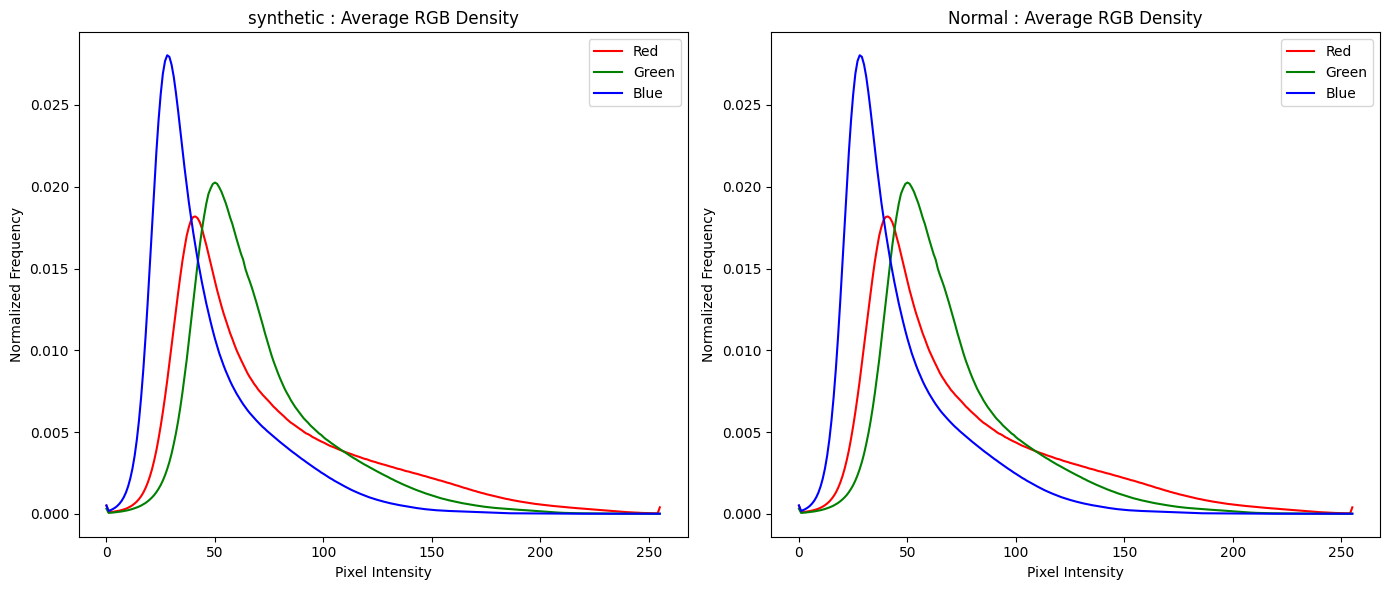

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

def compute_avg_rgb_density(directory):
    """
    Compute the average normalized RGB histograms (density) for all images in the given directory.
    Returns three arrays: avg_hist_r, avg_hist_g, avg_hist_b for the Red, Green, and Blue channels.
    """
    # Initialize histogram accumulators for each channel
    hist_r_total = np.zeros(256)
    hist_g_total = np.zeros(256)
    hist_b_total = np.zeros(256)
    count = 0

    # Loop through all files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith(('png', 'jpg', 'jpeg', 'tif')):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)  # Read in BGR format
            if image is None:
                continue

            # Convert image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Calculate the number of pixels in the image
            num_pixels = image_rgb.shape[0] * image_rgb.shape[1]
            
            # Compute normalized histograms (density) for each channel
            hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256]).flatten() / num_pixels
            hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256]).flatten() / num_pixels
            hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256]).flatten() / num_pixels
            
            # Accumulate the histograms
            hist_r_total += hist_r
            hist_g_total += hist_g
            hist_b_total += hist_b
            count += 1

    if count == 0:
        raise ValueError("No images found in directory: " + directory)

    # Compute average histograms
    avg_hist_r = hist_r_total / count
    avg_hist_g = hist_g_total / count
    avg_hist_b = hist_b_total / count

    return avg_hist_r, avg_hist_g, avg_hist_b


normal_state_name=""
# Replace these with your actual image directories for Zone 1 and Zone 2
# synthetic = '/home/umang.shikarvar/distance_exp/synthetic_haryana/images'

normal = f'../data/region_performance/{normal_state_name}_same_class_count_10_120_1000/images'
synthetic=normal

# Compute average RGB densities for each zone
avg_hist_r_zone1, avg_hist_g_zone1, avg_hist_b_zone1 = compute_avg_rgb_density(synthetic)
avg_hist_r_zone2, avg_hist_g_zone2, avg_hist_b_zone2 = compute_avg_rgb_density(normal)


# Define a function to compute similarity between two histograms using correlation
def histogram_similarity(hist1, hist2):
    """
    Compare two histograms using correlation metric.
    """
    # Convert to float32 for cv2.compareHist
    return cv2.compareHist(hist1.astype('float32'), hist2.astype('float32'), cv2.HISTCMP_CORREL)

# Compute similarity for each channel
sim_r = histogram_similarity(avg_hist_r_zone1, avg_hist_r_zone2)
sim_g = histogram_similarity(avg_hist_g_zone1, avg_hist_g_zone2)
sim_b = histogram_similarity(avg_hist_b_zone1, avg_hist_b_zone2)

print("RGB Histogram Similarity:")
print(f"R channel similarity: {sim_r:.4f}")
print(f"G channel similarity: {sim_g:.4f}")
print(f"B channel similarity: {sim_b:.4f}")
# # Print the computed histogram values for each zone
# print("Zone 1 Average RGB Density:")
# print("Red Channel:", avg_hist_r_zone1)
# print("Green Channel:", avg_hist_g_zone1)
# print("Blue Channel:", avg_hist_b_zone1)

# print("\nZone 2 Average RGB Density:")
# print("Red Channel:", avg_hist_r_zone2)
# print("Green Channel:", avg_hist_g_zone2)
# print("Blue Channel:", avg_hist_b_zone2)

# Plot the average RGB densities for visual comparison
plt.figure(figsize=(14, 6))

# Plot for Zone 1
plt.subplot(1, 2, 1)
plt.plot(avg_hist_r_zone1, color='red', label='Red')
plt.plot(avg_hist_g_zone1, color='green', label='Green')
plt.plot(avg_hist_b_zone1, color='blue', label='Blue')
plt.title('synthetic : Average RGB Density')
plt.xlabel('Pixel Intensity')
plt.ylabel('Normalized Frequency')
plt.legend()

# Plot for Zone 2
plt.subplot(1, 2, 2)
plt.plot(avg_hist_r_zone2, color='red', label='Red')
plt.plot(avg_hist_g_zone2, color='green', label='Green')
plt.plot(avg_hist_b_zone2, color='blue', label='Blue')
plt.title('Normal : Average RGB Density')
plt.xlabel('Pixel Intensity')
plt.ylabel('Normalized Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG16 and remove the classifier for feature extraction
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
feature_extractor = nn.Sequential(*list(vgg16.features.children()))
feature_extractor.eval()

# Define preprocessing transformation
transform = transforms.Compose([
    # Uncomment if resizing is needed:
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Uncomment normalization if desired:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

def extract_features_from_directory(directory, model, transform, batch_size=64):
    """
    Extract features for all images in the given directory using batch processing.
    Returns a numpy array of feature vectors and a list of image paths.
    """
    features_list = []
    image_paths = []
    
    # Temporary lists for batch processing
    batch_images = []
    batch_paths = []
    
    # Iterate over all files in the directory
    for file in os.listdir(directory):
        if file.lower().endswith(('png', 'jpg', 'jpeg', 'tif')):
            image_path = os.path.join(directory, file)
            try:
                image = Image.open(image_path).convert('RGB')
            except Exception as e:
                print(f"Error opening image {image_path}: {e}")
                continue
            image_tensor = transform(image)
            batch_images.append(image_tensor)
            batch_paths.append(image_path)
            
            # If we've reached the batch size, process the batch
            if len(batch_images) == batch_size:
                batch_tensor = torch.stack(batch_images, dim=0).to(device)
                with torch.no_grad():
                    batch_features = model(batch_tensor)
                # Flatten the features
                batch_features = batch_features.view(batch_features.size(0), -1)
                features_list.append(batch_features.cpu().numpy())
                image_paths.extend(batch_paths)
                batch_images, batch_paths = [], []
    
    # Process any remaining images in the last batch
    if batch_images:
        batch_tensor = torch.stack(batch_images, dim=0).to(device)
        with torch.no_grad():
            batch_features = model(batch_tensor)
        batch_features = batch_features.view(batch_features.size(0), -1)
        features_list.append(batch_features.cpu().numpy())
        image_paths.extend(batch_paths)
    
    # Concatenate all features into one numpy array
    features_array = np.concatenate(features_list, axis=0)
    return features_array, image_paths

# # Define directories for Zone 1 and Zone 2 images (update these paths)
# zone1_dir = '/path/to/zone1_images'  # Update with your directory path for Zone 1 images
# zone2_dir = '/path/to/zone2_images'  # Update with your directory path for Zone 2 images

# Extract features for all images in each zone using batch processing
features_zone1, image_paths_zone1 = extract_features_from_directory(normal, feature_extractor, transform, batch_size=16)
features_zone2, image_paths_zone2 = extract_features_from_directory(synthetic, feature_extractor, transform, batch_size=16)

# Compute pairwise cosine similarity between all images from Zone 1 and Zone 2
similarity_matrix = cosine_similarity(features_zone1, features_zone2)

# Calculate the average similarity across all pairs
average_similarity = np.mean(similarity_matrix)

print("Pairwise Cosine Similarity Matrix Shape:", similarity_matrix.shape)
print("Average Cosine Similarity between Zone 1 and Zone 2 images: {:.4f}".format(average_similarity))


/home/rishabh.mondal/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pairwise Cosine Similarity Matrix Shape: (687, 687)
Average Cosine Similarity between Zone 1 and Zone 2 images: 0.3188


## This is for checking original images sturecture and the sythetic images structure of the same zone. It is for checking the quality of the synthetic images the reconstructed image is closer to the original image.

In [50]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import imageio.v2 as imageio  # or simply import imageio
noemal_state_name="test_bihar"
# Set the path for the normal image (make sure this is a file, not a folder)
normal_image_path = f'../data/region_performance/{normal_state_name}_same_class_count_10_120_1000/images'
#access the first image in the folder
normal_files = [f for f in os.listdir(normal) if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif'))]
if not normal_files:
    raise ValueError("No normal images found in directory.")
normal_image_path = os.path.join(normal, normal_files[3])  # using the first image in the folder


# Set the directory for synthetic images and pick one image file
synthetic_dir = '/home/umang.shikarvar/experiment/synthetic_bihar/images'
# synthetic_dir=normal
synthetic_files = [f for f in os.listdir(synthetic_dir) if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif'))]
if not synthetic_files:
    raise ValueError("No synthetic images found in directory.")
synthetic_image_path = os.path.join(synthetic_dir, synthetic_files[3])  # using the first image in the folder

def calculate_metrics(image1_path, image2_path):
    # Read the images
    img1 = imageio.imread(image1_path)
    img2 = imageio.imread(image2_path)
    
    # Compute PSNR
    psnr_value = compute_psnr(img1, img2)
    
    # Compute SSIM; set multichannel=True for RGB images
    ssim_value, ssim_map = compute_ssim(img1, img2, multichannel=True, full=True,win_size=3)
    
    return psnr_value, ssim_value, ssim_map

psnr_val, ssim_val, ssim_map = calculate_metrics(normal_image_path, synthetic_image_path)
print("PSNR:", psnr_val, "dB")
print("SSIM:", ssim_val)



PSNR: 15.547675669947127 dB
SSIM: 0.49845308969039653
